## Erddap to Grid for Prawler

Using erddap as the data source, obtain each profile, filter out calibration profiles and provide interpolated/gridded dataset.

Gridding parameters:
Pressure - 1m
Time - 1hr

__pyversion__==3.6   
__author__==S.Bell

In [23]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2018-10-25 07:41:06.390308


In [24]:
%matplotlib inline

### connecting and basic information

In [25]:
import warnings
#remove the numpy/pandas/cython warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed,")

from erddapy import ERDDAP
import pandas as pd
import numpy as np
from netCDF4 import date2num, num2date
from scipy import interpolate

In [26]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean

In [27]:
server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

In [28]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='PRAWLER'))

In [29]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 8 tabledap, 0 griddap, and 0 wms endpoints.'

In [30]:
prawlers = df['Dataset ID'].values
print(prawlers)

['erddap_4fd3_fb30_b89f' 'erddap_17bsitae_prawler'
 'erddap_17ckitaem2a_prawler' 'erddap_18bsitaepr2a_prawler'
 'erddap_18mtitaepr1a_prawler' 'erddap_17ckitaem2a_met'
 'erddap_18bsitaepr2a_met' 'erddap_18mtitaepr1a_met']


In [31]:
variables = [e.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in prawlers]
print(variables)

[['Chlorophyll', 'time', 'depth', 'latitude', 'Salinity', 'longitude'], ['Chlorophyll', 'time', 'depth', 'latitude', 'Salinity', 'longitude'], ['Chlorophyll', 'time', 'SigmaT', 'Turbidity', 'depth', 'latitude', 'Temperature', 'Oxy_Temperature', 'Salinity', 'longitude', 'Oxy_Sat', 'Oxy_Conc'], ['Chlorophyll', 'time', 'depth', 'latitude', 'Salinity', 'longitude'], ['Chlorophyll', 'time', 'depth', 'latitude', 'Salinity', 'longitude'], ['time', 'wind_speed', 'relative_humidity', 'wind_from_direction', 'northward_wind', 'latitude', 'air_temperature', 'air_pressure', 'longitude', 'eastward_wind'], ['time', 'wind_speed', 'relative_humidity', 'wind_from_direction', 'northward_wind', 'latitude', 'air_temperature', 'air_pressure', 'longitude', 'eastward_wind'], ['time', 'wind_speed', 'relative_humidity', 'wind_from_direction', 'northward_wind', 'latitude', 'air_temperature', 'air_pressure', 'longitude', 'eastward_wind']]


### retrieving and plotting data

In [32]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='erddap_18mtitaepr1a_prawler'

d.variables =  [
 'profile_id',
 'Temperature',
 'Salinity',
 'Chlorophyll',
 'Turbidity',
 'latitude',
 'longitude',
 'depth',
 'time',
 'Oxy_Conc',
 'Oxy_Sat'
]

d.constraints = {
    'time>=': '2016-01-01T00:00:00Z',
    'time<=': '2018-10-10T00:00:00Z',
    'latitude>=': 45,
    'latitude<=': 90,
    'longitude>=': 180,
    'longitude<=': 210
}

In [33]:
d.get_download_url()

'http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/erddap_18mtitaepr1a_prawler.csv?profile_id,Temperature,Salinity,Chlorophyll,Turbidity,latitude,longitude,depth,time,Oxy_Conc,Oxy_Sat&time>=1451606400.0&time<=1539129600.0&latitude>=45&latitude<=90&longitude>=180&longitude<=210'

In [34]:
df = d.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.head()

,profile_id,Temperature,Salinity,Chlorophyll,Turbidity,latitude,longitude,depth,Oxy_Conc,Oxy_Sat
time,,,,,,,,,,
2018-05-05 02:32:35,18mtitaepr1a_p0003,1.584,32.143,0.602,1.898,60.026001,187.210007,5.1,338.38095,101.626205
2018-05-05 02:32:43,18mtitaepr1a_p0003,1.586,32.137,0.753,1.476,60.026001,187.210007,4.4,338.50867,101.664220
2018-05-05 02:32:51,18mtitaepr1a_p0003,1.584,32.138,0.728,1.476,60.026001,187.210007,4.8,338.39890,101.627150
2018-05-05 02:32:59,18mtitaepr1a_p0003,1.584,32.137,0.753,1.687,60.026001,187.210007,4.9,338.21445,101.570950
2018-05-05 02:33:07,18mtitaepr1a_p0003,1.584,32.137,0.728,1.476,60.026001,187.210007,4.3,338.42032,101.632490


In [35]:
df.tail()

,profile_id,Temperature,Salinity,Chlorophyll,Turbidity,latitude,longitude,depth,Oxy_Conc,Oxy_Sat
time,,,,,,,,,,
2018-08-18 13:34:28,18mtitaepr1a_p1807,6.292,32.149,0.753,1.054,60.026001,187.210007,38.4,272.69653,91.80347
2018-08-18 13:34:36,18mtitaepr1a_p1807,6.226,32.163,0.803,1.476,60.026001,187.210007,39.5,272.39093,91.57170
2018-08-18 13:34:44,18mtitaepr1a_p1807,6.204,32.161,0.778,1.687,60.026001,187.210007,40.7,271.83176,91.33622
2018-08-18 13:34:52,18mtitaepr1a_p1807,6.200,32.157,1.029,2.531,60.026001,187.210007,41.8,271.20570,91.11490
2018-08-18 13:35:00,18mtitaepr1a_p1807,6.192,32.157,1.004,2.320,60.026001,187.210007,42.6,270.79663,90.96095


### Interpolating and Gridding

#### Gridding Parameters

Set pressure interval to 1m and build a grid from 0-50m

In [36]:
### vertically grid data to evenly space gridspoints
# deployment depth has a maximum value - set at 50 generically
interval = 1 #m
press_grid = np.arange(0,50,interval) #1m

#### Temperature

We need to isolate the calibration park&holds first and remove them from the gridded analysis for Temperature/Salinity/Chlorophyl/Turbidity
We may wish to use them for the oxygen.

In [38]:
#groupby profile id
dfsg = df.groupby('profile_id')

In [39]:
def profile(cast,press_grid=np.arange(0,51,1),fillgaps=True):
    """ For a single profile, take median values
    Linearly interpolate to fillgaps"""
    #skip profile if std of depth is less than 1 - likely a park and hold
    if np.std(dfsg.get_group(cast)['depth']) <= 1.0:
        #calibration profile
        return
    else:
        # full profile
        #initialize profile parameters
        profiledata = {'Salinity': [],
                      'Temperature': [],
                      'Chlorophyll': [],
                      'Turbidity': [],
                      'Oxy_Sat': [],
                      'Oxy_Conc': []}

        #fill variables for each profile, taking the median if multiple values within same depth bin
        # and making NaN if no values
        for pg in press_grid:
            """ Take the median value if multiple samples occur within same depth bin"""
            for parameter in profiledata.keys():
                if not parameter in ['Statistics']:
                    ireg_ind = np.where((dfsg.get_group(cast)['depth'] > pg) & (dfsg.get_group(cast)['depth'] <= pg+interval))
                    profiledata[parameter] = np.hstack((profiledata[parameter], dfsg.get_group(cast)[parameter][ireg_ind[0]].median()))
                else:
                    profiledata['Statistics'] = np.hstack((profiledata['Statistics'], ireg_ind[0].size))

        for parameter in profiledata.keys():
            if fillgaps:
                mask = np.isnan(profiledata[parameter])
                profiledata[parameter][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), profiledata[parameter][~mask], right=-100000)

        profiledata['datetime'] = dfsg.get_group(cast).index[0].to_pydatetime()
        return(profiledata)

def time_interp(date_min,date_max,dt=1.0/24.0):
    dt_min = date2num(date_min -datetime.timedelta(seconds=60*date_min.minute + date_min.second),'Days since 0001-1-1')
    time_grid = np.arange(dt_min,date2num(date_max,'Days since 0001-1-1'),dt) #grid limits -> set to top of hour
    
    return(time_grid)

In [40]:
profiledata_filled = {}

for profileid in list(dfsg.groups.keys()):
    if profileid.endswith('00'):
        print("{profileid} of {number}".format(profileid=profileid, number=list(dfsg.groups.keys())[-1]))
    tmp = profile(profileid,press_grid=press_grid)
    if tmp:
        profiledata_filled.update({profileid: tmp})

18mtitaepr1a_p0100 of 18mtitaepr1a_p1807
18mtitaepr1a_p0200 of 18mtitaepr1a_p1807
18mtitaepr1a_p0300 of 18mtitaepr1a_p1807
18mtitaepr1a_p0400 of 18mtitaepr1a_p1807
18mtitaepr1a_p0500 of 18mtitaepr1a_p1807
18mtitaepr1a_p0600 of 18mtitaepr1a_p1807
18mtitaepr1a_p0700 of 18mtitaepr1a_p1807
18mtitaepr1a_p0800 of 18mtitaepr1a_p1807
18mtitaepr1a_p0900 of 18mtitaepr1a_p1807
18mtitaepr1a_p1000 of 18mtitaepr1a_p1807
18mtitaepr1a_p1100 of 18mtitaepr1a_p1807
18mtitaepr1a_p1200 of 18mtitaepr1a_p1807
18mtitaepr1a_p1300 of 18mtitaepr1a_p1807
18mtitaepr1a_p1400 of 18mtitaepr1a_p1807
18mtitaepr1a_p1500 of 18mtitaepr1a_p1807
18mtitaepr1a_p1600 of 18mtitaepr1a_p1807
18mtitaepr1a_p1700 of 18mtitaepr1a_p1807
18mtitaepr1a_p1800 of 18mtitaepr1a_p1807


In [70]:
parameter='Oxy_Sat'
np2d=[]
np2d = [np2d + list(v[parameter]) for k,v in profiledata_filled.items()]


In [71]:
time_grid = time_interp(profiledata_filled[list(profiledata_filled.keys())[0]]['datetime'],
                        profiledata_filled[list(profiledata_filled.keys())[-1]]['datetime'])

date_time = [date2num(v['datetime'],'Days since 0001-1-1') for k,v in profiledata_filled.items()]

In [72]:
mesh_grid_func = interpolate.interp2d(press_grid,date_time,np.array(np2d),kind='linear',bounds_error=False,fill_value=-100000)
mesh_grid = mesh_grid_func(press_grid,time_grid)

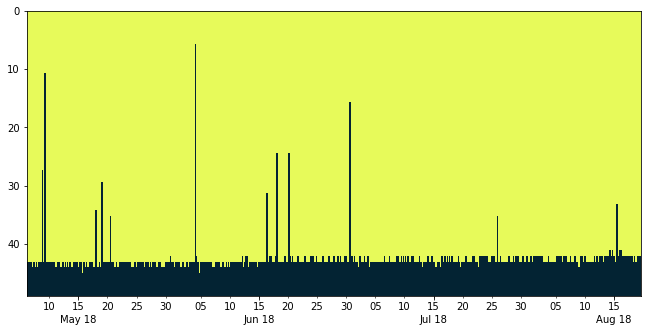

In [73]:
extent = (time_grid.min(),
          time_grid.max(), 
          press_grid.max(), 
          press_grid.min()) # extent of the plots

#plt.imshow(mesh_grid.T,extent=extent, vmin=31.7, vmax=32.3, cmap=cmocean.cm.haline)
fig = plt.figure(figsize=(22,5.25))
ax = plt.subplot(1,1,1)
cs = plt.imshow(mesh_grid.T,extent=extent, vmin=3, vmax=15, cmap=cmocean.cm.thermal)
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=[5,10,15,20,25,30]))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
ax.xaxis.set_tick_params(which='major', pad=15)


### Save output to csv

In [74]:
np.savetxt('16BS_'+parameter+'.csv',mesh_grid,fmt='%.3f')

In [75]:
np.savetxt('16BS_coords_depth.csv',press_grid,fmt='%.1f')
np.savetxt('16BS_coords_time.csv',time_grid,fmt='%.8f')